## Setup

### Import Necessary Standard Libraries

In [1]:
# Customize display of non-standard values in notebook output
from IPython.display import display, clear_output

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy as np

from string import ascii_uppercase
import collections
import itertools
import os

# Plot interactive graphs as notebook outputs
%matplotlib inline
plt.style.use('dark_background')

### Import Neural Network Library 
[\[Library Source\]](https://github.com/mkpro118/neural_network)

In [21]:
# Symbols are listed in order of appearance
from neural_network.layers import Dense

from neural_network.models import Sequential

from neural_network.model_selection import train_test_split
from neural_network.model_selection import StratifiedKFold

from neural_network.preprocess import Scaler
from neural_network.preprocess import OneHotEncoder

from neural_network.metrics import confusion_matrix
from neural_network.metrics import accuracy_score
from neural_network.metrics import accuracy_by_label

---
## Analyzing the data

### Overview of the data

The dataset contains 300 labeled samples for each uppercase letter in the English Alphabet. Each sample is a 28x28 image of the letter, flattened into a 1D Array

In [3]:
data = np.genfromtxt('Data/handwritten_letters.csv', delimiter=',', skip_header=True, dtype=int)
data.shape

(7800, 785)

The first column of the dataset contains the labels. The remaining 784 columns contain the pixels making up the image of the letter.

In [4]:
features = data[:, 1:]
labels = data[:, 0]
names = ascii_uppercase

display(f'{features.shape = } | {labels.shape = }')

'features.shape = (7800, 784) | labels.shape = (7800,)'

### Visualizing Handwritten Letters

To get a visual understanding of the data, we can randomly select and display a handwritten letter from each class.
<a id="visualize"></a>

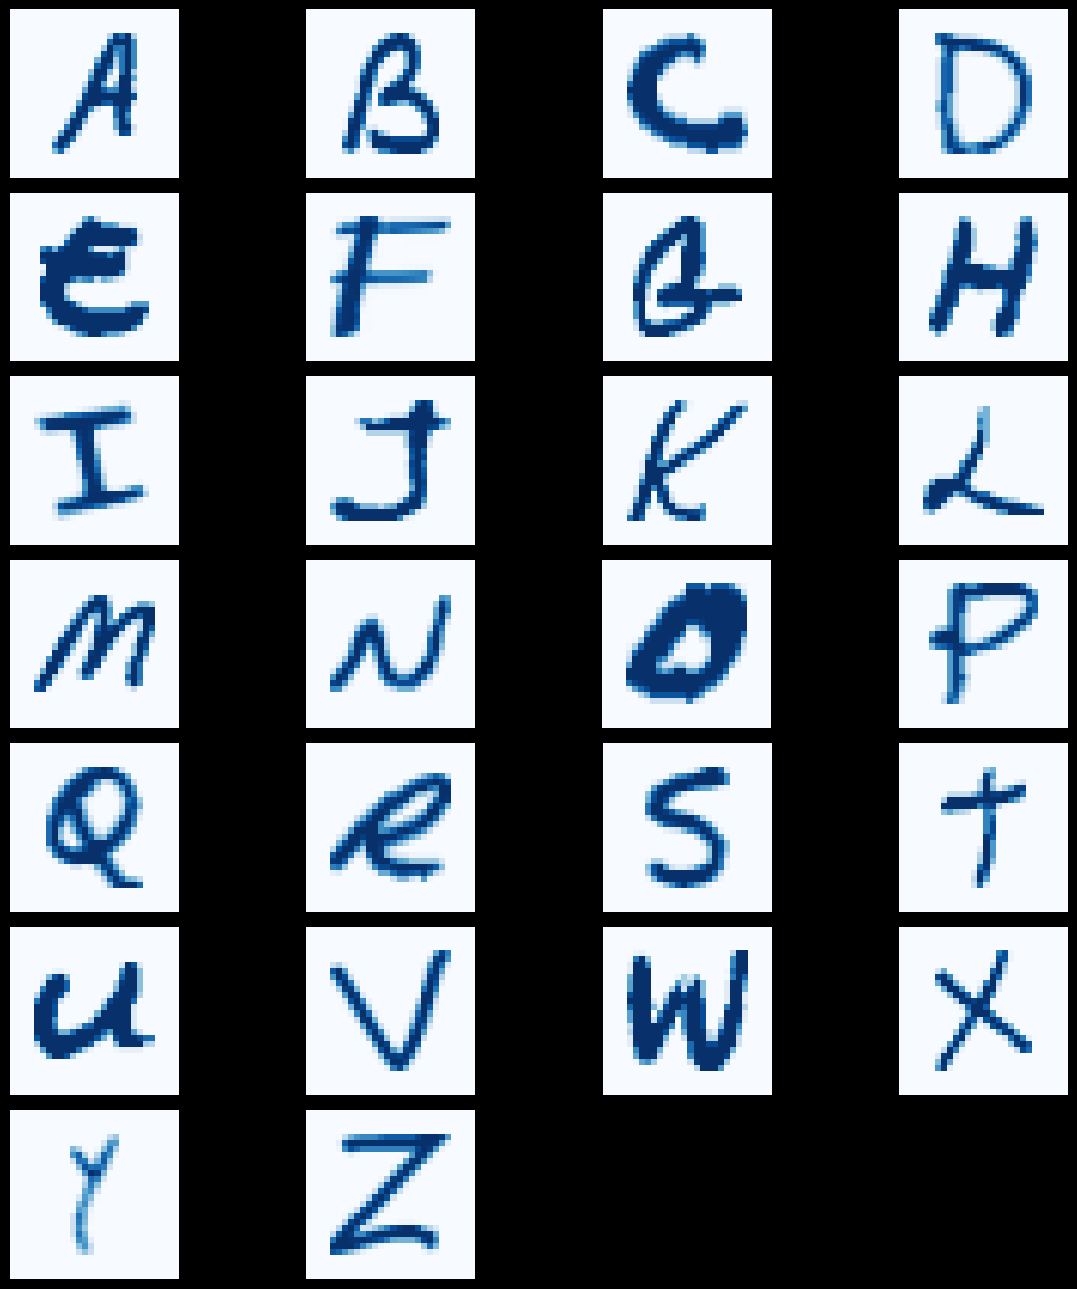

In [5]:
fig, axs = plt.subplots(nrows=7, ncols=4, figsize=(12, 13), squeeze=False)

# plt.subplots returns a (7, 4) array
# we convert that to a flat tuple for straightforward indexing
axs = np.ravel(axs)

rng = np.random.default_rng()

for i, label in enumerate(np.unique(labels)):
    axs[i].imshow(rng.choice(features[labels == label]).reshape(28, 28), cmap='Blues')
    axs[i].axis('off')

for ax in axs[-2:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

---
## Classifying Handwritten Letters into Uppercase English Alphabet

In this section, we will dive into the exciting task of classifying images of handwritten letters from the uppercase English alphabet. Our goal is to build a neural network-based classifier that can accurately predict the letter represented by each image. By the end of this section, we aim to have a robust model capable of recognizing various handwritten uppercase letters.

### Building the Neural Network

Next, we will construct our neural network, specifically a multi-layer neural network, to tackle the handwritten letter classification task. This architecture consists of an input layer, one or more hidden layers, and an output layer.

To train the multi-layer neural network, we will use the Stochastic Gradient Descent (SGD) optimization technique. SGD enables us to update the network's parameters, which include weights and biases, iteratively during training. The goal of the training process is to minimize the loss function, which measures the difference between the predicted outputs and the actual labels.

The hidden layers will introduce non-linearity to the model, allowing it to learn complex patterns and relationships in the handwritten letter data. Each neuron in the hidden layers will apply an activation function to the weighted sum of its inputs, contributing to the network's ability to capture intricate features.

By training our multi-layer neural network with SGD, we aim to optimize the model's parameters to accurately classify the handwritten letters, resulting in a powerful and versatile classifier for handwritten uppercase English letters.

#### Neural Network Architecture

- ##### Input Layer
  The input layer will consist of 784 nodes, each corresponding to a pixel in the flattened image.

- ##### Hidden Layers
  We can experiment with different numbers of hidden layers and nodes in each layer to find the optimal architecture for our classifier. I prefer using powers of 2 for the number of nodes in the each hidden layer.

- ##### Output Layer
  The output layer will have 26 nodes, one for each letter in the uppercase English alphabet (A to Z). We will use a softmax activation function to obtain probability scores for each letter.

#### The Dense Layer
The Dense layer is a fundamental component in neural networks. It connects every neuron in the layer to every neuron in the preceding and succeeding layers, forming a fully connected structure. 

The Dense layer performs a linear transformation on the input data, calculating weighted sums of the inputs and adding biases for each neuron. These values are then passed through an activation function to introduce non-linearity. The Dense layer enables the neural network to learn and represent complex patterns in the data, making it a critical building block for various tasks, including classification and regression.

The Dense layer from my neural_network library has the following simplified signature  [\[source\]](https://github.com/mkpro118/neural_network/blob/b7782a8ddba40f60f6b20dbad695615b00a0fe59/neural_network/layers/dense.py#L18-L136)

```py
class Dense:
    def __init__(self, nodes: int, *,
                 input_shape: int = None,
                 activation: str = None,
                 trainable: bool = True,
                 use_bias: bool = True,
                 weights_constraints: Sequence = None,
                 bias_constraints: Sequence = None,
                 learning_rate: float = 1e-2,
                 name: str = None):
```

Here, the relevant parameters are
- *nodes*: The number of neurons (also known as units or neurons) in the Dense layer.
- *input_shape*: The shape of the input data that will be fed into the Dense layer.
- *activation*: The activation function applied to the output of each neuron.
- *name*: A unique name given to the Dense layer.

#### The Sequential Model
The Sequential Model is one of the fundamental and straightforward architectures in deep learning, commonly used for building neural networks. It is a linear stack of layers where the output of one layer serves as the input to the next layer. The Sequential Model is particularly useful for creating feedforward neural networks, where data flows from the input layer to the output layer through a series of hidden layers. It's architecture also allows easy backpropagation with automatic differentiation.

The Sequential Model from my neural_network library has the following simplified signature  [\[source\]]()
```py
class Sequential:
    def __init__(self, *, layers: Union[list, tuple] = None,
                 from_model: 'Sequential' = None,
                 num_checkpoints: int = 5,
                 name: str = None):
```

Here, the relevant parameters are
- *layers*: The list of dense layers in this model.
- *name*: A unique name given to the Sequential Model.

<a id='create_model'></a>

In [6]:
def get_model() -> Sequential:
    '''Returns an untrained compiled Sequential model'''
    # Define the network
    network = [
        Dense(512, input_shape=784, activation='tanh', name='Input'),
        Dense(128, activation='tanh', name='Hidden'),
        # Dense(64, activation='tanh', name='Hidden 2'),
        # Dense(32, activation='tanh', name='Hidden 3'),
        Dense(26, activation='softmax', name='Output'),
    ]

    # Encapsulate the network in a Sequential model
    model = Sequential(layers=network,
                       name='Handwritten Letter Classifier')

    # Compile and build  the model
    model.compile(cost='crossentropy', metrics=['accuracy_score'])

    return model

# Example Model
get_model().summary()



Sequential Model: 'Handwritten Letter Classifier' with 3 layers
Input Shape: (784,)
-------------------------------------
| # | Layer |         Info          |
-------------------------------------
| 1 | Dense | Input with 512 nodes  |
| 2 | Dense | Hidden with 128 nodes |
| 3 | Dense | Output with 26 nodes  |
-------------------------------------
Total Trainable Params = 470,938
Total Non-Trainable Params = 0




---
### Model Selection
Model selection is a critical step in machine learning, where we determine the best model and its hyperparameters to achieve optimal performance. In this section, we will explore two commonly used techniques for splitting data into training and testing sets: holdout method and Stratified KFold splitting.

#### 1. Holdout Method:

The holdout method, also known as train-test split, is a straightforward approach to split the dataset into two parts: a training set and a testing set. The training set is used to train the model, while the testing set is used to evaluate its performance on unseen data.

The *train_test_split* function from my library has the following simplified signature [\[source\]](https://github.com/mkpro118/neural_network/blob/b7782a8ddba40f60f6b20dbad695615b00a0fe59/neural_network/model_selection/train_test_split.py#L11-L94)

```py
def train_test_split(X: np.ndarray,
                     y: np.ndarray, 
                     test_size: float = 0.2,
                     random_state: int = None,
                     stratify: bool = True) -> tuple:
```

Here, the relevant parameters are:
- *X*: The features to split
- *y*: The labels to split
- *test_size*: The percentage of samples from X in the test set

Note: This function automatically stratifies the data, which means there will be (approximately) equal number of samples from each class in both the training and testing data.
<a id="train_test_split"></a>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features.astype(float), labels, test_size=0.3)

display(
    f'{X_train.shape = }',
    f'{X_test.shape = }',
    f'{y_train.shape = }',
    f'{y_test.shape = }'
)

'X_train.shape = (5460, 784)'

'X_test.shape = (2340, 784)'

'y_train.shape = (5460,)'

'y_test.shape = (2340,)'

#### 2. Stratified K-Fold Cross Validation

Stratified KFold is a cross-validation technique that divides the data into K subsets or folds, while ensuring that each fold retains the same class distribution as the original dataset. This split is used to evaluate the performance of the model during training.

The *StratifiedKFold* class from my library has the following simplified signature [\[source\]](https://github.com/mkpro118/neural_network/blob/b7782a8ddba40f60f6b20dbad695615b00a0fe59/neural_network/model_selection/stratified_kfold.py#L14-L94)

```py
class StratifiedKFold:
    def __init__(self, n_splits: int = 5,
                 shuffle: bool = False,
                 random_state: int = None):
```

Here, the relevant parameters are
- *n_splits*: The number of partitions on the data (the K).
<a id="stratified_kfold"></a>

In [8]:
n_splits = 5  # This variable is also used in a future cell
skf = StratifiedKFold(n_splits=5)

cv_splitter = skf.split(X_train, y_train)  # stratified KFold splitter

---
### Data Preprocssing

Before training our neural network, we need to preprocess the data to make it suitable for training.

#### 1. Rescaling

We will scale down the pixel values from the range \[0, 255\] to \[0, 1\]. This ensures that our model doesn't encounter numerical instability during training. To avoid leakage of data, we will fit our scaler with the **training data only**. (*While data leakage is not possible in this case, we will still follow standard practice*)

The *Scaler* class from my library has the following simplified signature [\[source\]](https://github.com/mkpro118/neural_network/blob/b7782a8ddba40f60f6b20dbad695615b00a0fe59/neural_network/preprocess/scaler.py#L13-L85)
```py
class Scaler:
    def __init__(self, start: Number = -1, end: Number = 1):
```

Here, the relevant parameters are:
- *start*: The minimum value after rescaling
- *end*: The maximum value after rescaling
<a id="rescaling"></a>

In [9]:
scaler = Scaler(start=0., end=1.).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

display(f'min = {np.min(X_train)} | max = {np.max(X_train)}')

'min = 0.0 | max = 1.0'

#### 2. One-Hot Encoding the Labels

In multi-class classification tasks, we need to convert the categorical labels (letters) into a numerical format that is suitable for training our neural network. One-hot encoding is a technique that transforms categorical labels into binary vectors, where each vector corresponds to a specific category (letter). Each vector will have a value of 1 at the index representing the category, and all other values will be 0.

[\[source\]](https://github.com/mkpro118/neural_network/blob/b7782a8ddba40f60f6b20dbad695615b00a0fe59/neural_network/preprocess/one_hot_encoder.py#L17-L88)

<a id="one_hot_encoding"></a>

In [10]:
encoder = OneHotEncoder()
encoder = encoder.fit(labels)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
display(f'{y_train.shape = } | {y_test.shape = }')

'y_train.shape = (5460, 26) | y_test.shape = (2340, 26)'

---
### Setup for Training the Neural Network Models
<a id="training"></a>

While we're technically ready to start training the neural network, I'd like to be able to visualize training by plotting real-time graphs of the network's progress. This step is crucial to gain valuable insights into the model's performance during training and helps us identify potential issues or areas of improvement.

In this section, we describe the setup for real-time graph plotting and its significance in monitoring the neural network's training progress.

#### 1. Model Initialization
We begin by initializing multiple neural network models. Each model represents a unique instance of the neural network, and will be trained on different partitions of the training data. The models are created using the [*get_model()*](#create_model) function we created earlier.

<a id="model_initialization"></a>

In [11]:
models = [get_model() for _ in range(n_splits)]

#### 2. Initialize Trainers for Each Stratified K-Fold Split
The neural network models are trained using a ___custom trainer___.

Trainers are [generators](https://book.pythontips.com/en/latest/generators.html#id1) that run exactly 1 training iteration. After every call to *\_\_next__*, i.e. \[ *next(trainer)* \], trainers yield a dictionary with the following information
1. Overall Accuracy
2. Overall Loss
3. Validation Accuracy
4. Validation Loss

We will use these statistics to plot a real time chart of the model's training


Similar to how callbacks in popular ML libraries allow running subroutines between training iterations, using this custom generator allows us to fully control the rate of training, and allows execution of any subroutines in between training iterations.

You can learn more about generators [here](https://book.pythontips.com/en/latest/generators.html#id1)
<a id="get_trainers"></a>

In [12]:
def get_trainers(epochs: int = 300) -> list:
    return [
        models[i].fit(
            X_train[train],
            y_train[train],
            epochs=epochs,
            steps_per_epoch=10,
            validation_data=(X_train[validate], y_train[validate]),
            verbose=False,    # The output is huge otherwise
            get_trainer=True, # Get trainer (a generator) instead of training
        ) for i, (train, validate) in enumerate(cv_splitter)
    ]

#### 3. Defining the Subplots for Real-Time Performance Visualization:
To gain real-time insights into the training progress, we set up dynamic accuracy and loss plots. We create a 2x2 subplot to visualize the validation accuracy, validation loss, overall accuracy, and overall loss for each model during training. The plots are continuously updated at regular intervals (update_frequency) to provide a live representation of the models' performance.
<a id="get_graphs"></a>

In [13]:
def get_graphs() -> tuple[plt.Figure, tuple[plt.Axes]]:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    
    ax1.set_title('Validation Accuracy')
    ax2.set_title('Validation Loss')
    ax3.set_title('Overall Accuracy')
    ax4.set_title('Overall Loss')
    
    for ax in (ax1, ax3):
        ax.set_ylabel('Accuracy')
    for ax in (ax2, ax4):
        ax.set_ylabel('Loss')
    for ax in (ax1, ax3, ax3, ax4):
        ax.set_xlabel('Epochs')

    return (fig, (ax1, ax2, ax3, ax4))

# Number of training iterations between graph updates 
update_frequency = 2

# Each color represents a model on the graphs
colors = ['lightblue', 'hotpink', 'lightgreen', 'orange', 'red']

#### 4. Training History and Best Metrics Tracking:
We maintain a *history* dictionary to record the training statistics for each model during each training iteration. This allows us to keep track of the model's progress over time. Additionally, we use a separate best dictionary to monitor the best validation accuracy and loss observed among all models at regular intervals through the training process.

<a id="get_history_dict"></a>

In [14]:
def get_history_dict() -> dict:
    history = {
        num: {
            'overall': collections.defaultdict(list),
            'validation': collections.defaultdict(list),
        } for num in range(len(models))
    }
    
    history.update({
        'best': {
            'overall': {
                'accuracy': -np.inf,
                'loss': np.inf,
            },
            'validation': {
                'accuracy': -np.inf,
                'loss': np.inf,
            },
        },
    })
    return history

---
### Training the Models
Now that we have completed the necessary setup for training the neural network models and prepared our real-time visualization framework, we are ready to start training the models.

#### Some comments on the code below
While we have the option to utilize matplotlib's *FuncAnimation* class to generate real-time graphs, it updates the plot on every frame of the animation, potentially multiple times per second. In our scenario, this frequent updating is not efficient since we only intend to update the plots at regular intervals throughout the training, which may not necessarily be in sync with *FuncAnimation*'s update loop.

In a standard terminal-based Python environment, we may not have any other viable approach. However, in an IPython notebook, we have the advantage of clearing the cell output and re-displaying the updated graph only when it becomes available. This more selective approach allows us to visualize the model's progress efficiently and avoid unnecessary overhead during the training process.

Regrettably, this approach does lead to some rather lengthy and slightly convoluted code, which may be off-putting. However, the complexity is warranted by the desire to efficiently achieve real-time updates of the graphs, displaying the training statistics for each model at regular intervals.

Hopefully the comments are useful in understand the code below. For a more comprehensive understanding of the code, a step-by-step explanation is provided [here](#Explanation-of-the-Training-Code).
<a id="training"></a>

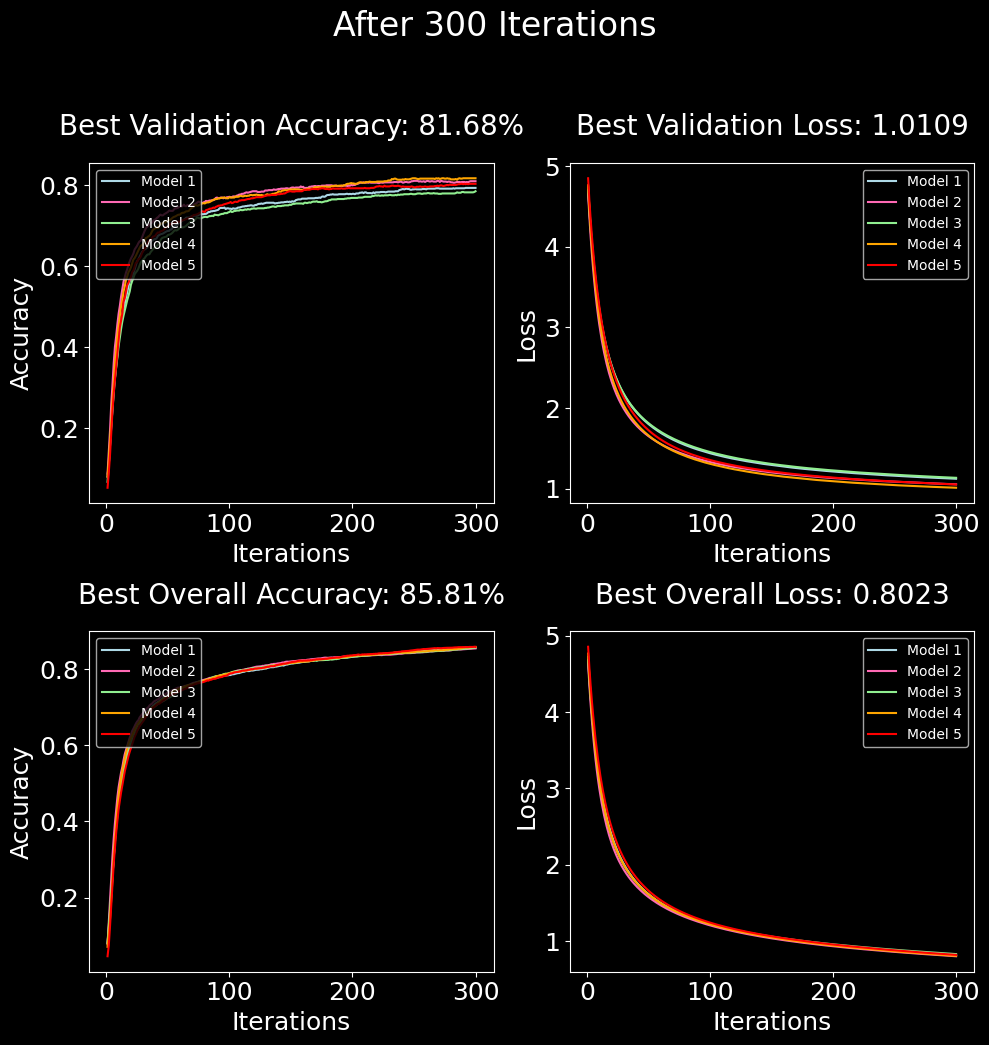

In [15]:
def train(epochs: int = 300):
    trainers = get_trainers(epochs)
    history = get_history_dict()
    
    fig, (ax1, ax2, ax3, ax4) = get_graphs()
    clear_output(wait=False)
    
    for iterations in itertools.count(start=1):
        try:
            # Run a training iteration
            data = tuple(map(next, trainers))
            # Here we use a list comprehension instead of
            # normal for loops because list comprehensions
            # are slightly faster
            [
                history[num][type_][metric].append(data[num][type_][metric])
                for num in range(len(models))
                for type_ in data[num].keys()
                for metric in data[num][type_].keys()
            ]
        except (StopIteration, IndexError):  # Generators stop as training completes
            break
        
        # Lazy updates to speed up training
        if iterations % update_frequency != 0:
            continue
    
        # Update with iterations count
        fig.suptitle(f'After {iterations} Iterations', fontsize=24, y=1.04)
    
        # Clear all axes to plot again
        for ax in (ax1, ax2, ax3, ax4):
            ax.cla()
    
        # Live Plots
        for num in range(len(models)):
            # Update Validation Accuray Plot
            ax1.plot(
                np.arange(len(history[num]['validation']['accuracy'])) + 1,
                history[num]['validation']['accuracy'],
                color=colors[num],
                label=f'Model {num + 1}'
            )
    
            # Update Validation Loss Plot
            ax2.plot(
                np.arange(len(history[num]['validation']['loss'])) + 1,
                history[num]['validation']['loss'],
                color=colors[num],
                label=f'Model {num + 1}'
            )
    
            # Update Overall Accuray Plot
            ax3.plot(
                np.arange(len(history[num]['overall']['accuracy'])) + 1,
                history[num]['overall']['accuracy'],
                color=colors[num],
                label=f'Model {num + 1}'
            )
    
            # Update Overall Loss Plot
            ax4.plot(
                np.arange(len(history[num]['overall']['loss'])) + 1,
                history[num]['overall']['loss'],
                color=colors[num],
                label=f'Model {num + 1}'
            )
            
        # Update the titles with best accuracy and loss information
        x = max(history[num]["validation"]["accuracy"][-1] for num in range(len(models)))
        x = max(history['best']['validation']['accuracy'], x)
        history['best']['validation']['accuracy'] = x
        ax1.set_title(f'Best Validation Accuracy: {np.around(x * 100, 2)}%', fontsize=20, pad=20)
        ax1.legend(loc='upper left')
        
        x = min(history[num]["validation"]["loss"][-1] for num in range(len(models)))
        x = min(history['best']['validation']['loss'], x)
        history['best']['validation']['loss'] = x
        ax2.set_title(f'Best Validation Loss: {np.around(x, 4)}', fontsize=20, pad=20)
        ax2.legend(loc='upper right')
        
        x = max(history[num]["overall"]["accuracy"][-1] for num in range(len(models)))
        x = max(history['best']['overall']['accuracy'], x)
        history['best']['overall']['accuracy'] = x
        ax3.set_title(f'Best Overall Accuracy: {np.around(x * 100, 2)}%', fontsize=20, pad=20)
        ax3.legend(loc='upper left')
        
        x = min(history[num]["overall"]["loss"][-1] for num in range(len(models)))
        x = min(history['best']['overall']['loss'], x)
        history['best']['overall']['loss'] = x
        ax4.set_title(f'Best Overall Loss: {np.around(x, 4)}', fontsize=20, pad=20)    
        ax4.legend(loc='upper right')
        
        for ax in (ax2, ax4):
            ax.set_xlabel('Iterations', fontsize=18)
            ax.set_ylabel('Loss', fontsize=18)
    
        for ax in (ax1, ax3):
            ax.set_xlabel('Iterations', fontsize=18)
            ax.set_ylabel('Accuracy', fontsize=18)
            
        for ax in (ax1, ax2, ax3, ax4):
            ax.tick_params(axis='both', labelsize=18)
        
        fig.tight_layout()
            
        clear_output(wait=False)
        display(fig)

        # This is required to completely draw the plots
        # See https://stackoverflow.com/a/53760972
        plt.pause(0.1)
train()

---
### Saving the model

After training a neural network model, it is essential to save its learned parameters and architecture to disk so that it can be reused or deployed for making predictions on new, unseen data. Saving the model allows us to preserve the knowledge acquired during the training process, ensuring that we do not need to retrain the model from scratch each time we want to use it.

In [16]:
def save_models():
    for i, model in enumerate(models, start=1):
        model.save(f'Saved Models/Model {i}.json')

save_models()

---
### Testing the Model

In this section, we assess the performance of our trained neural network models by testing them against holdout data. Holdout data refers to a subset of the dataset that was not used during the training process and is reserved exclusively for evaluating the models' generalization capabilities. The holdout data for this task was computed [here](#train_test_split)

In [26]:
def make_predictions():
    return [model.predict(X_test, classify=True) for model in models]

def get_cmats():
    return [confusion_matrix(y_test, prediction) for prediction in predictions]

predictions = make_predictions()
cmats = get_cmats()

In [27]:
for i in range(len(predictions)):
    acc = accuracy_score(y_true=y_test, y_pred=predictions[i]) * 100
    acc = np.around(acc, 2)
    display(f'Model {1 + i}\'s accuracy: {acc}%')

"Model 1's accuracy: 88.46%"

"Model 2's accuracy: 100.0%"

"Model 3's accuracy: 84.62%"

"Model 4's accuracy: 100.0%"

"Model 5's accuracy: 96.15%"

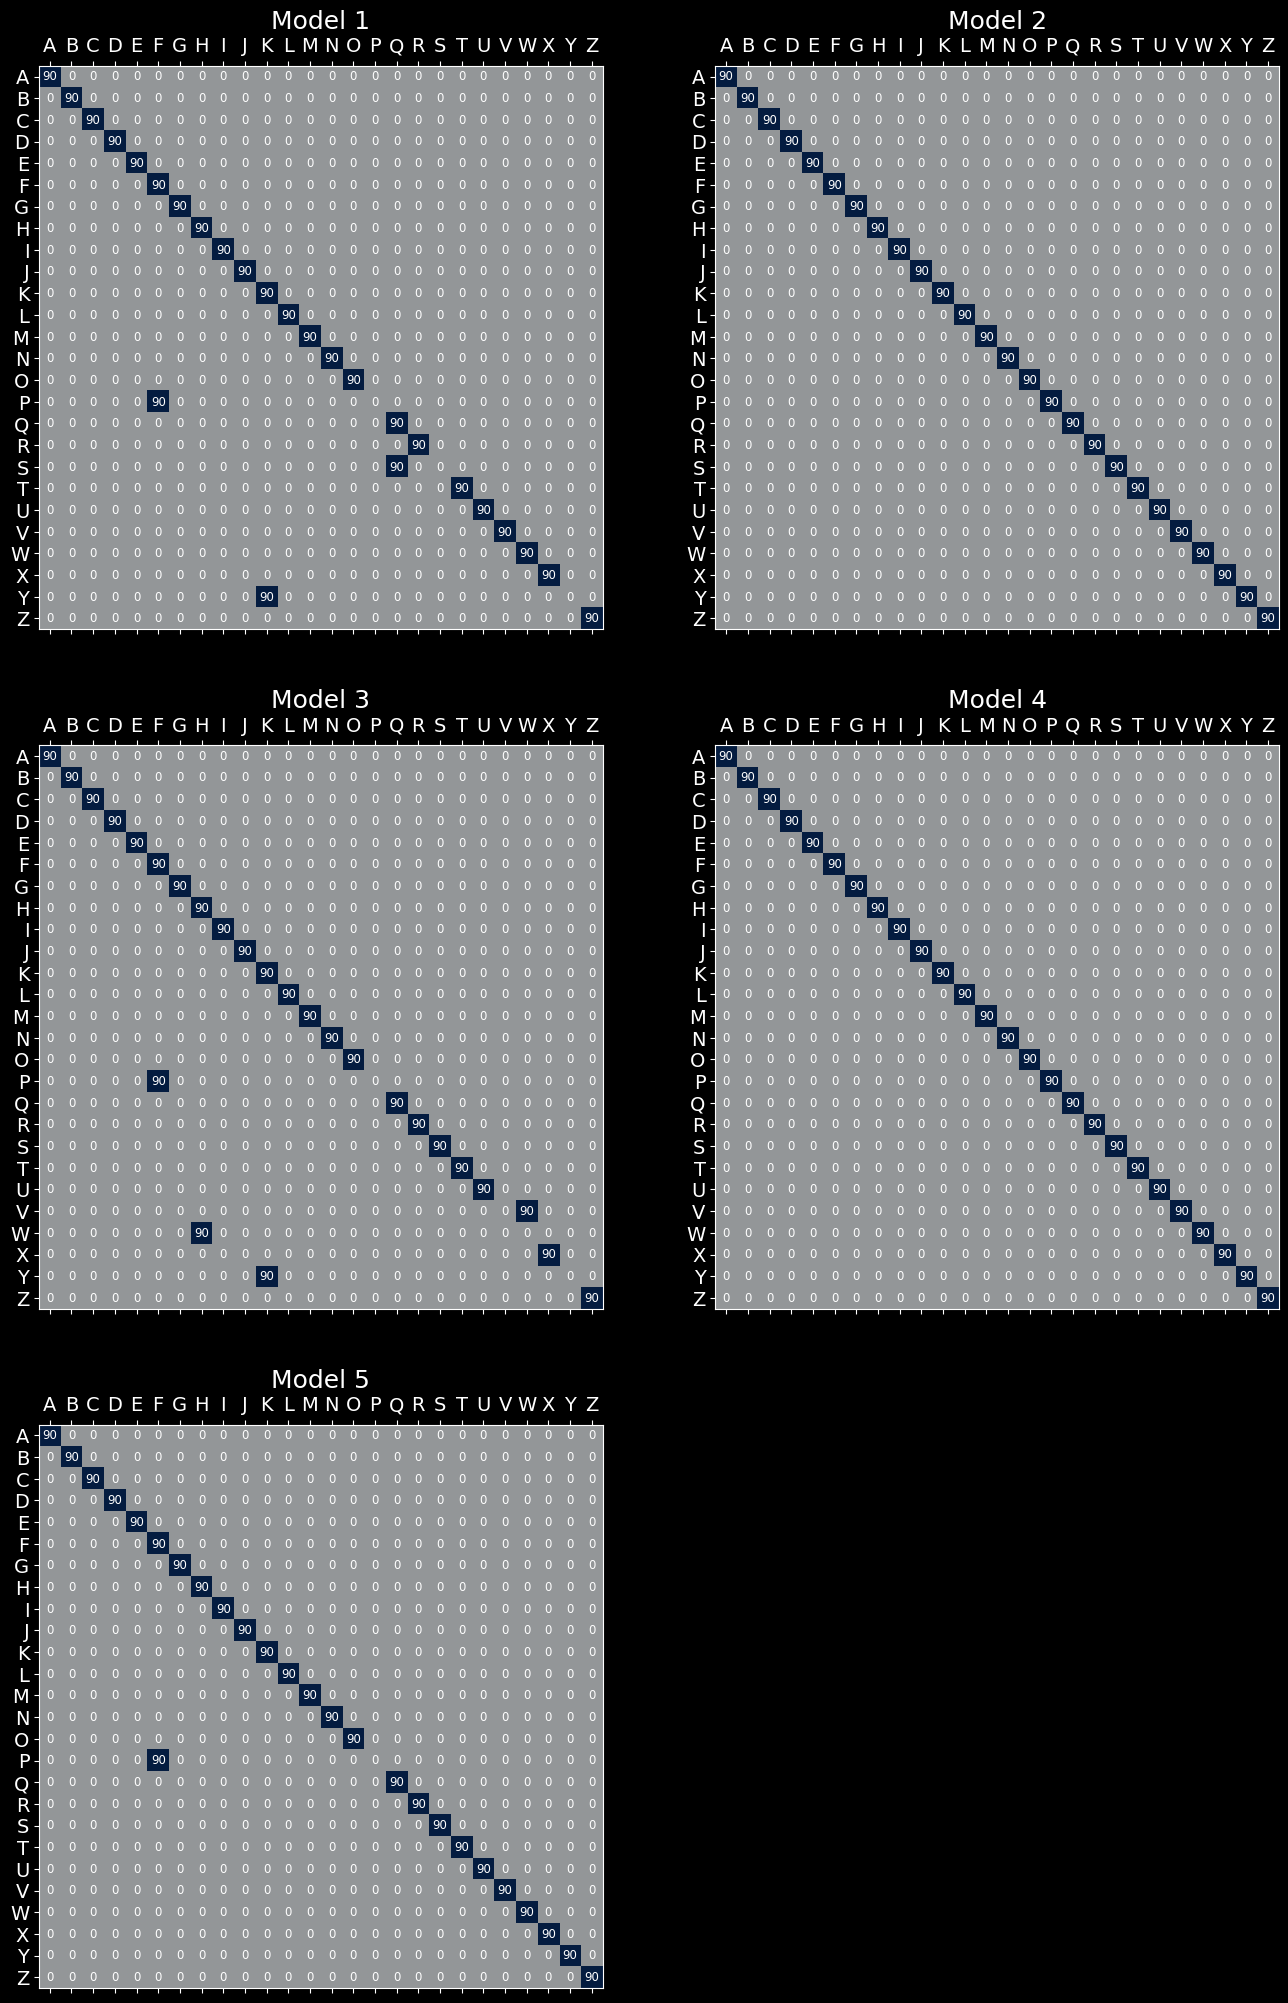

In [28]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 25))
axs = np.ravel(axs)
axs[-1].axis('off')
axs = axs[:-1]

for i, (ax, cmat) in enumerate(zip(axs, cmats), start=1):
    ax.matshow(cmat, cmap='Blues', alpha=0.6)
    ax.set_xticks(np.arange(len(names)))
    ax.set_xticklabels(map(str, names), fontsize=14)
    ax.set_yticks(np.arange(len(names)))
    ax.set_yticklabels(map(str, names), fontsize=14)
    ax.set_title(f'Model {i}', fontsize=18)

    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            ax.text(x=j, y=i, s=cmat[i, j], va='center', 
                    ha='center', size='small', color='white')
plt.show()

---
## Handwritten Letter Classification Results

In this section, we present the results of our handwritten letter classification task using five different neural network models. Each model was evaluated on its accuracy in correctly classifying handwritten letters from a dataset of 28x28 pixel images.

### Model Performance

The following are the accuracy scores obtained for each model:

- **Model 1**: Accuracy: 88.46%
- **Model 2**: Accuracy: 100.0%
- **Model 3**: Accuracy: 84.62%
- **Model 4**: Accuracy: 100.0%
- **Model 5**: Accuracy: 96.15%

### Analysis

The results indicate significant variations in the performance of the different models. Notably, Model 2 and Model 4 achieved perfect accuracy, correctly classifying all handwritten letters. These models demonstrated exceptional learning capability and were able to generalize well to unseen data, resulting in flawless predictions.

On the other hand, Model 1 and Model 3 achieved lower accuracies of 88.46% and 84.62%, respectively. While these accuracies may seem relatively lower than those of the other models, they still demonstrate reasonably effective performance. It is essential to consider factors such as model complexity, dataset size, and training duration while interpreting these results. Additionally, an unfortunate random initialization of weights and biases may have a negative impact on a model's training. An unlucky Stratifield K-Fold split may also have a negative impact.

Model 5 achieved an accuracy of 96.15%, positioning it as one of the top-performing models. Its ability to achieve high accuracy suggests that it is proficient in capturing the intricate patterns and features in the handwritten letters, making it a reliable classifier.

### Interesting Observations
- Models 2 & 4 have been leading as the top models from the start.
- Model 2 consistently had the better overall loss
- Model 4 consistently had the better validation loss
- Model 1 incorrectly classifies R as P
- Models 1 & 3 incorrectly classify K as Y
- Model 3 incorrectly classifies V as W
- Models 1, 3 & 5 incorrectly classify P as F
- Model 5 has only one flaw, it cannot distinguish P from F, otherwise it would also be perfect.

### Insights and Next Steps

The variability in model performance highlights the importance of carefully selecting the model architecture and hyperparameters for a given task. Further investigations into the characteristics of the models, such as the number of hidden layers, the number of neurons in each layer, and the activation functions, may shed light on the reasons behind their individual performances.

To improve the models with lower accuracies, one could consider implementing regularization techniques, such as Dropout or L2 regularization, to mitigate overfitting. Additionally, data augmentation techniques may be explored to increase the diversity of the training data and enhance the models' generalization capabilities.

Further experimentation with different neural network architectures, hyperparameter tuning, and advanced optimization algorithms can help identify optimal configurations for improving overall accuracy.

In conclusion, the results of our handwritten letter classification task demonstrate the potential of neural network models in effectively recognizing and classifying handwritten letters. By understanding the strengths and weaknesses of each model, we can make informed decisions to enhance their performance and achieve even better results in future iterations of the task.

---
### Explanation of the Training Code

Here, we will go through the code in the [train()]() function, and understand what each block of code does.

The 
```py
clear_output(wait=False)
```
function call is used to clear the output of the cell, if any. This is also used to update the live plots during training.

---

An infinite `for` loop is used to the training iterations. Although it is visually better to use `while` loops for infinite iterations, using a for loop with `itertools.count` allows easier access to the iteration we're on. The `itertools.count` class generates an infinite sequence of numbers, starting from `start`. The loop will continue until it the trainer generators throw a `StopIteration` Exception, or if some other Exception occurs. A `StopIteration` Exception signifies that the generator has completed execution.


In the for loop, we use a `try/except` to properly handle breaking infinite the loop.


The first line inside the try block
```py
data = tuple(map(next, trainers))
```
calls Python's `next` function on each of the trainers objects using the built-in `map` class and stores the results in a tuple called data. The `map` class applies the `next` function on each element of the trainers list. This line runs a single training iteration for each of the models.

---

The next block of code
```py
[
    history[num][type_][metric].append(data[num][type_][metric])
    for num in range(len(models))
    for type_ in data[num].keys()
    for metric in data[num][type_].keys()
]
```
uses a list comprehension to update the history dictionary with the results from the current training iteration. The history dictionary stores the performance metrics for each model during training.
To better understand that snippet, let's take a look at the structure of the history dictionary
```txt
{
    Model1: { 
        overall: {
            accuracy: /* list of model1's accuracy on the entire training data at each iteration */
            loss: /* list of model1's loss on the entire training data at each iteration */
        }
        validation: {
            accuracy: /* list of model1's accuracy on the validation data at each iteration */
            loss: /* list of model1's loss on the validation data at each iteration */
        } 
    }
    /* Model2-Model5 are similar to Model 1 */
    best: {
        overall: {
            accuracy: /* list of the best accuracy on the entire training data after `update_frequency` iterations across all models */
            loss: /* list of the best loss on the entire training data after `update_frequency` iterations across all models */
        }
        validation: {
            accuracy: /* list of the best accuracy on the validation data after `update_frequency` iterations across all models */
            loss: /* list of the best loss on the validation data after `update_frequency` iterations across all models */
        } 
    }
}
```

With this in mind, let's further understand the three for loops,
- `for num in range(len(models))`: iterates over each model (stored in variable `num`)
- `for type_ in data[num].keys()`:iterates over the `model[num]`'s' data keys, which are *"overall"* and *"validation"* (stored in variable `type_`)
- `for metric in data[num][type_].keys()`: iterates over the values of `model[num][type_]`'s keys, which are *"accuracy"* and *"loss"* (stored in variable `metric`)

---

The next block of code
```py
if iterations % update_frequency != 0:
    continue
```
trivially checks if the current iteration is a multiple of the update_frequency variable. If it is not, the loop will continue to the next iteration without updating the plots. If the current iteration is a multiple of the update_frequency, the code will update the plots with the latest performance metrics.

---

The next block resets the figure to re-plot
```py
fig.suptitle(f'After {iterations} iterations', fontsize=24, y=1.04)

for ax in (ax1, ax2, ax3, ax4):
    ax.cla()
```
The first line inside this block updates the title of the figure with the current number of iterations.
The next two lines of code clears all of the axes in preparation for plotting new data.

---

The next block of code
```py
for num in range(len(models)):
    ax1.plot(
        np.arange(len(history[num]['validation']['accuracy'])) + 1,
        history[num]['validation']['accuracy'],
        color=colors[num],
        label=f'Model {num + 1}'
    )
    # Other axes omitted for brevity
```
uses another for loop to iterate over each of the models and update their respective plots with their latest performance metrics. Inside this loop, four separate calls are made to the plot method of each axis object (`ax1`, `ax2`, `ax3`, and `ax4`) to update each plot with new data.

---

After all of the plots have been updated, the following block of code
```py
x = max(history[num]["validation"]["accuracy"][-1] for num in range(len(models)))
x = max(history['best']['validation']['accuracy'], x)
history['best']['validation']['accuracy'] = x
ax1.set_title(f'Best Validation Accuracy: {np.around(x * 100, 2)}%', fontsize=20, pad=20)
ax1.legend(loc='upper left')

# Other axes omitted for brevity
```
updates their titles with information about their best performance so far.
Finally, some additional formatting is applied to each axis object, such as setting their labels and tick parameters.

---

At the end of each iteration, the figure is displayed using the display function

A short pause is introduced using the plt.pause function in order to fully render the plot images. This is **required** to properly render the plots. See [this stackoverflow post](https://stackoverflow.com/a/53760972) about it.